# Librairies à importer : 

In [61]:
# Manipulation de données et visualisation : 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modèles statistique / Machine Learning :  
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Facultatives
import os
import time
import talib

# Importation des données et format Date_time : 

En l'état du code, il faut que le dataframe contienne :
- une colonne au format date_time de pandas, nommée "Open_time"
- une colonne avec des int ou float, nommée "Close"

In [2]:
df = pd.read_csv("D:/Bastien/DESU Data Science/Projet/Data Binance 1min/BTCUSDT_15min_binance.csv", index_col=0)
df["Open_time"] = pd.to_datetime(df["Open_time"])

In [3]:
df

,Open_time,Open,High,Low,Close
0,2017-08-17 04:00:00,4261.48,4280.56,4261.48,4261.48
1,2017-08-17 04:15:00,4261.48,4270.41,4261.32,4261.45
2,2017-08-17 04:30:00,4280.00,4310.07,4267.99,4310.07
3,2017-08-17 04:45:00,4310.07,4313.62,4291.37,4308.83
4,2017-08-17 05:00:00,4308.83,4328.69,4304.31,4304.31
...,...,...,...,...,...
208779,2023-07-31 22:45:00,29206.88,29210.00,29201.00,29209.99
208780,2023-07-31 23:00:00,29210.00,29210.00,29192.50,29192.50
208781,2023-07-31 23:15:00,29192.51,29218.97,29190.00,29195.96
208782,2023-07-31 23:30:00,29195.95,29240.50,29195.95,29236.97


# Fonctions du programme : 

## 1) Préparation des données : 
- Fonction qui prépare des matrices de données X et y pour les modèles. 

**Nom des colonnes nécessaires :** 

- df : Dataframe de données en entrée qui doit contenir les colonnes "Close" et "Open_time"
- t : nombre d'instant dans le passé à inclure  
- h : Horizon de la valeur à prédire  
- start_date : date et heure du début de sélection des données , format string : "YYYY-MM-DD HH:MM:SS"  
- end_date : date et heure de fin de sélection des données , format string : "YYYY-MM-DD HH:MM:SS"  
- features : Nom des colonnes à inclure dans les variables explicatives X. Si plusieurs types de variables, il faut que la variable "prix de clôture" soit positionnée en dernier élement de la liste,   
- sequence_output : True / False pour prévoir une séquence de prix en sortie de ${t_0}$ -> h, ou juste la valeur h  


In [27]:
def prepare_data(df: pd.DataFrame, t: int, h: int, start_date: str, end_date: str, on_return=False, features=None, sequence_output=False):
    """
    Prépare les données pour la prédiction de séries temporelles
    
    Arguments:
        df (pd.DataFrame): DataFrame original contenant les données.
        t (int): Taille de la fenêtre temporelle.
        h (int): Horizons de prédiction.
        start_date (str): Date de début pour le filtrage des données.
        end_date (str): Date de fin pour le filtrage des données.
        on_return (bool, optional): Si True, calcule le rendement. Par défaut à False.
        features (list, optional): Liste des colonnes à utiliser comme features. Par défaut à ["Close"].
        sequence_output (bool, optional): Si True, sort une séquence de `h` valeurs. Par défaut à False.
    
    Returns:
        tuple: Retourne un tuple contenant les éléments suivants:
            X (np.array): Matrice des features.
            y (np.array): Vecteur des labels.
            X_indices (np.array): Indices de temps pour X.
            y_indices (np.array): Indices de temps pour y.
            df_selected (pd.DataFrame): DataFrame filtré.
    
    Exemple:
        >>> X, y, X_indices, y_indices, df_selected = prepare_data(df, 20, 5, '2020-01-01 00:00:00', '2021-01-01 00:00:00', on_return=True)
    """
    # Conversion des dates pour la sélection
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Utilisation de `query` pour une meilleure performance lors de la sélection par date
    df_selected = df.query('@start_date <= Open_time <= @end_date')
    
    # Supprimer les NaN avant tout traitement
    df_selected = df_selected.dropna()

    if on_return:
        df_selected = calculate_return(df_selected)

    # Ajout de la possibilité d'utiliser plusieurs colonnes et prévoir une séquence    
    selected_columns = features if features else ["Close"]
    
    num_samples = len(df_selected) - t - h + 1
    num_features = len(selected_columns) * t
    
    # Préallocation pour la performance
    X = np.zeros((num_samples, num_features))
    y = np.zeros(num_samples)

    X_indices, y_indices = [], []

    for i in range(num_samples):
        
        if on_return:
            X[i] = df_selected.iloc[i:i+t]["return"].values
            X_indices.append(df_selected.index[i:i+t].values)

            y1 = df_selected.iloc[i+t-1]["Close"]
            y2 = df_selected.iloc[i+t+h-1]["Close"]

            y[i] = np.round(((y2 - y1) / y1), 5)
            y_indices.append(df_selected.index[i+t+h-1])
            
            
        else:
            
            X[i] = df_selected.iloc[i:i+t][selected_columns].values.flatten()
            X_indices.append(df_selected.index[i:i+t].values)
            
        if sequence_output:
            y[i] = df_selected.iloc[i+t:i+t+h-1]["Close"].values
            y_indices.append(df_selected.index[i+t:i+t+h-1])
            
        else:
            y[i] = df_selected.iloc[i+t+h-1]["Close"]
            y_indices.append(df_selected.index[i+t+h-1])

    # Conversion en numpy array
    X_indices, y_indices = np.array(X_indices), np.array(y_indices)
    X = np.nan_to_num(X)  # Remplacer les NaN par zéro si nécessaire
    
    return X, y, X_indices, y_indices, df_selected

### Exemple : 

Features = **None** : ne prend que le prix de clôture

In [5]:
X, y, X_indices, y_indices, df_selected = prepare_data(
        df=df, t=5, h=2,
        start_date="2017-08-17 04:00:00", end_date="2023-07-31 23:45:00", 
        on_return=False, 
        features=None)

In [16]:
X_indices

array([[     0,      1,      2,      3,      4],
       [     1,      2,      3,      4,      5],
       [     2,      3,      4,      5,      6],
       ...,
       [208775, 208776, 208777, 208778, 208779],
       [208776, 208777, 208778, 208779, 208780],
       [208777, 208778, 208779, 208780, 208781]], dtype=int64)

In [17]:
y_indices

array([     6,      7,      8, ..., 208781, 208782, 208783], dtype=int64)

In [18]:
X

array([[ 4261.48,  4261.45,  4310.07,  4308.83,  4304.31],
       [ 4261.45,  4310.07,  4308.83,  4304.31,  4320.  ],
       [ 4310.07,  4308.83,  4304.31,  4320.  ,  4291.37],
       ...,
       [29243.31, 29216.49, 29237.05, 29206.88, 29209.99],
       [29216.49, 29237.05, 29206.88, 29209.99, 29192.5 ],
       [29237.05, 29206.88, 29209.99, 29192.5 , 29195.96]])

In [19]:
y

array([ 4291.37,  4315.32,  4330.  , ..., 29195.96, 29236.97, 29232.25])

## 2) Evaluation de la prédiction par rapport à la valeur test

In [20]:
def evaluate_prediction(y_pred, y_test, X_test, fees=0.001, on_return=False):
     """
    Évalue la qualité de la prédiction de mouvement du marché. La fonction renvoie un label indiquant si la prédiction est correcte, incorrecte, ou partiellement correcte.
    
    Arguments:
        y_pred (float or np.array): La prédiction de la valeur future.
        y_test (float or np.array): La valeur future réelle.
        X_test (float or np.array): La valeur présente.
        fees (float, optional): Les frais de transaction. Par défaut à 0.001, pour 0.1%
        on_return (bool, optional): Si True, utilise le rendement pour l'évaluation. Par défaut à False.
    
    Returns:
        int: Renvoie un label d'évaluation de la prédiction :
            - 2 : Prédiction et réalité sont tous deux au-dessus ou en-dessous des seuils, c'est-à-dire un trade gagnant.
            - 1 : La prédiction est dans la bonne direction mais pas suffisamment pour être un trade gagnant.
            - 0 : La prédiction est incorrecte.
    
    Exemple:
        >>> evaluate_prediction(105, 110, 100)
        >>> 2
    """
    seuil_long = 2 * fees
    seuil_short = 2 * -fees
    
    value_pred = np.round((y_pred - X_test) / X_test, 4)
    value_actual = np.round((y_test - X_test) / X_test, 4)
    
    if on_return:
        label = np.sign(y_pred) == np.sign(y_test)
    else:
        
        # trades gagnants :
        if value_pred and value_actual > seuil_long:
            label = 2
            
        elif value_pred and value_actual < seuil_short:
            label = 2
            
        # Trades perdants mais prédiction dans le bon sens :    
        elif value_pred and value_actual >= 0:
            label = 1
        
        elif value_pred and value_actual <= 0:
            label = 1
            
       # Prédiction raté :
        else:
            label = 0
    
    return int(label)

### Exemple :
Label renvoyé si la variation de la valeur prédite et la vraie valeur sont supérieures aux frais par rapport à la valeur de référence (X_test).

In [22]:
label = evaluate_prediction(y_pred=16500, y_test=16471, X_test=16300, fees=0.001)
print(label)

2


## 3) Prédiction et évaluation des prédictions :
Prédit les valeurs à partir d'un modèle de ML type régression. Les modèles sont fait en glissant d'un pas de 1, chaque modèle ne faisant qu'une prédiction. 
- napp :  Taille du jeu d'apprentissage. Type (int)
- t : Nombre d'instants dans le passsé. Type (int)
- h : Horizon de la valeur à prédire. Type (int)
- model_name : Nom du modèle de type régression. Type (string)
- window et step : permet d'isoler des blocs de valeurs prédites (peut être obsolète)

**Sortie :**

- predictions_list : Liste contenant une liste de valeurs prédites  
- actuals_list : Liste contenant une liste des valeurs tests (des vraies valeurs)  
- indices_list : Liste contenant une liste des indices des valeurs prédites, utilisés pour retrouver les données réelles dans la fonction trading  
- labels_list : Liste contenant une liste des labels d'évaluation des prédictions
- coefficients_list : Liste contenant une liste des coefficients si Régression Linéaire




In [37]:
def get_model_attributes(model):
    if hasattr(model, 'coef_') and hasattr(model, 'intercept_'):
        return model.coef_, model.intercept_
    return None, None

def make_predictions(X, y, X_indices, napp:int, t:int, h:int, model_name=LinearRegression, fees=0.001, window=None, step=None, on_return=False):
    """
    Effectue des prédictions en utilisant des modèles machine learning spécifiés par l'utilisateur, de type regréssion. 
    Le modèle est recalibré pour chaque prédiction sur un segment de données de taille 'napp'.

    Arguments:
        X (np.array): Matrice de features.
        y (np.array): Vecteur de la variable ciblée.
        X_indices (np.array): Indices temporels correspondant à X.
        napp (int): Taille du segment de données pour l'entraînement.
        t (int): Taille de la fenêtre temporelle.
        h (int): Horizon de prédiction.
        model_name (class, optional): Classe du modèle à utiliser (par exemple LinearRegression, RandomForest, etc.). Par défaut à LinearRegression.
        fees (float, optional): Les frais de transaction. Par défaut à 0.001, soit 0.1%.
        window (int, optional): Taille de la fenêtre de prédiction en nombre de pas. Par défaut à la taille de X.
        step (int, optional): Pas de glissement pour la fenêtre de prédiction. Par défaut à la taille de X.
        on_return (bool, optional): Si True, utilise le rendement pour l'évaluation. Par défaut à False.
        
    Returns:
        tuple: Un tuple contenant les listes suivantes :
            - predictions_list: Liste des valeurs prédites.
            - actuals_list: Liste des valeurs réelles.
            - indices_list: Liste des indices temporels.
            - labels_list: Liste des labels d'évaluation des prédictions.
            - coefficients_list: Liste des coefficients du modèle, si applicable.
    
    Exemple:
        >>> make_predictions(X, y, X_indices, 100, 20, 5, model_name=LinearRegression)
    """
    q = t + h - 1

    # Vérification des paramètres window et step qui servaient à diviser les prédictions en blocs (listes de liste)
    step_ = step or len(X) - napp - t - h
    window_ = window or len(X) - t - h
    
    # Listes pour stocker les prédictions, valeurs réelles, indices et étiquettes
    predictions_list, actuals_list, indices_list, labels_list, coefficients_list = [], [], [], [], []
    
    for i in range(0, len(X) - napp - t - h, step_):
        if window and step and (i + window_ > len(X) - napp - t - h):
            break
        
        if model_name == 'LinearRegression':
            model = LinearRegression()
            
        elif model_name == 'RandomForest':
            model = RandomForestRegressor(n_estimators=50)
        
        elif model_name == "XGBoost":
            model = XGBRegressor(n_estimators=50, learning_rate=0.05, gamma=0.1)
            
        else:
            raise ValueError("Modèle non pris en charge")
            
            
        # Utilisation des list comprehensions pour simplifier et optimiser
        results = [
            (
                model.fit(X[idx:idx + napp], y[idx:idx + napp]).predict(X[idx + napp + q].reshape(1, -1))[0],
                y[idx + napp + q],
                X_indices[idx + napp + q][-1],
                evaluate_prediction(
                    model.predict(X[idx + napp + q].reshape(1, -1))[0],
                    y[idx + napp + q],
                    X_test=X[idx + napp + q][-1],fees=fees),
                get_model_attributes(model)
            )
            for idx in range(i, i + window_)
            if idx < len(X) - napp - t - h - q
        ]
        
        predictions, actuals, indices, labels, coeffs = zip(*results)
        
        predictions_list.append(predictions)
        actuals_list.append(actuals)
        indices_list.append(indices)
        labels_list.append(labels)
        coefficients_list.append(coeffs)

        
    return predictions_list, actuals_list, indices_list, labels_list, coefficients_list


### Exemple : 

In [28]:
predictions_list, actuals_list, indices_list, labels_list, coefficients_list = make_predictions(X, y, X_indices, napp=250, t=5, h=2, model_name="LinearRegression", fees=0.001, window=None, step=None, on_return=False)

In [29]:
predictions_list

[(4091.4910163292043,
  4139.682465749896,
  4140.443055552972,
  4072.9947207211185,
  4132.437072503935,
  4143.898686762635,
  4136.916012449138,
  4132.6890323422795,
  4139.833542931505,
  4139.858677148654,
  4140.079735252278,
  4139.993757853517,
  4099.22878235178,
  4102.050823721453,
  4103.052383636703,
  4093.8605568699127,
  4074.900498906404,
  4085.169912872272,
  4061.5930070363324,
  4082.5244926547903,
  4094.2369519717868,
  4107.045018119856,
  4114.57973742466,
  4118.459238133391,
  4120.117953100273,
  4111.641901821809,
  4112.800193297852,
  4099.784778996281,
  4099.171415399102,
  4097.85272714265,
  4097.795388399181,
  4094.352960065077,
  4121.990460491953,
  4135.291365050398,
  4097.250292937084,
  4112.873150234966,
  4118.701458337604,
  4101.552243927739,
  4112.212554994921,
  4116.177425419052,
  4089.0120503268413,
  4106.392583017205,
  4137.393004482313,
  4147.779369191284,
  4143.003961138611,
  4167.804767252719,
  4178.868559559414,
  4178.3

In [36]:
# Longueur des listes, et longeur des sous-listes qui correspondent au nombre de prédictions : 
print("Longeur de la liste de prédictions :")
print(len(predictions_list))
print("Longeur de la sous-liste, correspond au nombre de prédictions :")
print(len(predictions_list[0]))
print("")

print("Longeur de la liste des valeurs réelles :")
print(len(actuals_list))
print("Longeur de la sous-liste valeurs réelles, correspond au nombre de prédictions :")
print(len(actuals_list[0]))
print("")

print("Longeur de la liste des indices :")
print(len(indices_list))
print("Longeur de la sous-liste indices, correspond au nombre de prédictions :")
print(len(indices_list[0]))
print("")


print("Longeur de la liste de labels :")
print(len(labels_list))
print("Longeur de la sous-liste labels, correspond au nombre de prédictions :")
print(len(labels_list[0]))
print("")

print("Longeur de la liste de coefficients :")
print(len(coefficients_list))
print("Longeur de la sous-liste coefficients, correspond au nombre de prédictions :")
print(len(coefficients_list[0]))

Longeur de la liste de prédictions :
1
Longeur de la sous-liste, correspond au nombre de prédictions :
208515

Longeur de la liste des valeurs réelles :
1
Longeur de la sous-liste valeurs réelles, correspond au nombre de prédictions :
208515

Longeur de la liste des indices :
1
Longeur de la sous-liste indices, correspond au nombre de prédictions :
208515

Longeur de la liste de labels :
1
Longeur de la sous-liste labels, correspond au nombre de prédictions :
208515

Longeur de la liste de coefficients :
1
Longeur de la sous-liste coefficients, correspond au nombre de prédictions :
208515


## 3) Simulation de trading :

Fonctions qui simulent un trading basé sur les prédictions obtenues.  
Conversion de la valeur numérique prédite en rendement par rapport au dernier prix.  
Entrée en position long si ce rendement est supérieur aux frais de transactions aller/retour, pareillement pour une vente à découvert.   
Montant par position fixe, défini par "portfolio / h", correspondant au nombre de positions simultanément ouvertes au maximum.

**Sortie :**
- Liste contenant 1 dataframe répertoriant tous les trades effectués sur la période. 


In [51]:
def calculate_position(entry_price, exit_price, capital_usd, fees, position_type):
    
    """
    Calcule le Profit & Loss (PnL) pour un seul trade.

    Paramètres:
        - entry_price (float) : Le prix auquel la position a été ouverte.
        - exit_price (float) : Le prix auquel la position a été fermée.
        - capital_usd (float) : Montant du capital alloué pour ce trade.
        - fees (float) : Frais de transaction.
        - position_type (str) : "LONG" ou "SHORT"

    Renvoie :
        - pnl_usd (float) : PnL en dollars américains.
        - pnl_percent (float) : PnL en pourcentage.
        - quantity (float) : Quantité de l'actif échangé.
    """
    
    multiplier = 1 if position_type == "LONG" else -1
    quantity = np.round((capital_usd / entry_price), 4)
    quantity -= np.round((quantity * fees), 4)

    position_out = multiplier * (exit_price - entry_price) * quantity
    position_out -= (position_out * fees)

    pnl_usd = np.round(position_out, 2) 
    pnl_percent = np.round((pnl_usd / capital_usd), 5)

    return pnl_usd, pnl_percent, quantity

def trading_strategy(dataframe, predictions_list, actuals_list, indices_list, coefficients_list, h, portfolio=100000, fees=0.001, on_return=False):
    
    """
    Effectue le backtest de la stratégie de trading en fonction des prédictions de l'apprentissage automatique.

    Paramètres :
        - dataframe (pd.DataFrame) : Données historiques du prix.
        - predictions_list (list) : Liste des prix/rendements prédits.
        - actuals_list (list) : Liste des prix/rendements réels.
        - indices_list (list) : Liste des indices correspondant aux valeurs prédites.
        - coefficients_list (list) : Liste des coefficients du modèle (uniquement pour la régression linéaire).
        - h (int) : Horizon de prédiction.
        - portfolio (float, optionnel) : Taille initiale du portefeuille en dollars américains.
        - fees (float, optionnel) : Frais de transaction.
        - on_return (bool, optionnel) : Si True, évalue en fonction des rendements.

    Renvoie :
        - trades_dfs_list (list de pd.DataFrame) : Liste de DataFrames, chacun contenant des informations sur les trades pour une période particulière.
    """
    
    trades_dfs_list = []
    benchmark_dfs_list = []
    
    # Montant investi par position
    capital_usd = portfolio / h
    
    open_positions = {'LONG': [], 'SHORT': []}
    
    # Seuil d'entrée en position long ou short
    seuil_long = 2 * fees
    seuil_short = 2 * -fees
    
    # Itération pour récupérer la liste principales des listes "predictions", "actuals", "coefficients" (si regression linéaire)
    for i, (predictions, actuals, coeffs) in enumerate(zip(predictions_list, actuals_list, coefficients_list)):
        trades_list = []
        benchmark_list = []
        
        # Itération sur chaque prédiction 
        for j in range(len(predictions)):
            
            # Récupération de l'indice à partir duquel la valeur est prédite.
            # Sert de référence pour parcourir le dataframe et simuler les trades. 
            idx = indices_list[i][j]
            predicted_value = predictions[j]
            coeff = coeffs[j]
            
            open_positions['LONG'] = [x for x in open_positions['LONG'] if x > idx]
            open_positions['SHORT'] = [x for x in open_positions['SHORT'] if x > idx]
            
            # On_return n'est plus utilisé. Conversion de la valeur du prix de clôture en rendement.
            if on_return == False:
                predicted_value = np.round(((predictions[j] - dataframe.loc[idx]["Close"]) / dataframe.loc[idx]["Close"]), 5)
                actual_value = np.round(((actuals[j] - dataframe.loc[idx]["Close"]) / dataframe.loc[idx]["Close"]), 5)

            if idx + h >= dataframe.index[-1]:
                continue  # Avoid index out of bounds error
            
            if predicted_value > seuil_long or predicted_value < seuil_short:
                position_type = "LONG" if predicted_value > seuil_long else "SHORT"
                
                open_positions[position_type].append(idx + h)
                
                entry_price = dataframe.loc[idx]["Close"]
                exit_price = dataframe.loc[idx + h]["Close"]
                
                pnl_usd, pnl_percent, quantity = calculate_position(entry_price, exit_price, capital_usd, fees, position_type)
                
                # Eléments répertoriés et calculés pour chaque trade 
                trade = {
                    "Date_entry":  dataframe.loc[idx]["Open_time"],
                    "Entry_price": entry_price,
                    "Date_exit": dataframe.loc[idx + h]["Open_time"],
                    "Exit_price": exit_price,
                    "Quantity": quantity,
                    "PnL_USD": pnl_usd,
                    "PnL_percent": pnl_percent,
                    "Position": position_type,
                    "Open_positions_LONG": len(open_positions['LONG']),
                    "Open_positions_SHORT": len(open_positions['SHORT']),
                    "Predicted_value": predictions[j],
                    "Actual_value": actuals_list[i][j],
                    "Coefficient": coeff,
                    "Win_loss": 1 if pnl_usd >= 0 else 0
                }
                trades_list.append(trade)
        # Conversion de la liste de trades en dataframe, et calcul de nouveaux indicteurs
        if len(trades_list) > 0:
            trades_df = pd.DataFrame(trades_list)
            trades_df["PnL_USD_cum"] = trades_df["PnL_USD"].cumsum()
            trades_df["Open_positions"] = trades_df['Open_positions_LONG'] + trades_df['Open_positions_SHORT']
            rolling_fund = trades_df["PnL_USD_cum"].min()
            trades_df["PnL_percent_portfolio"] = (trades_df["PnL_USD"] / (100000 + abs(rolling_fund))*100)
            trades_df["PnL_percent_cum"] = np.round(trades_df["PnL_percent_portfolio"].cumsum(), 2)
            trades_df["Peak"] = trades_df["PnL_USD_cum"].cummax()+1
            trades_df["Drawdown"] = ((trades_df["Peak"] - trades_df["PnL_USD_cum"]) / trades_df["Peak"])*100 
            trades_df["Date_entry"] = pd.to_datetime(trades_df["Date_entry"])
            trades_df["Date_exit"] = pd.to_datetime(trades_df["Date_exit"])
            
            
        else:
            # if no trades for this period, add an empty dataframe with the expected columns
            trades_df = pd.DataFrame(columns=["Date_entry", "Entry_price", "Date_exit", "Exit_price", "Quantity", "PnL_USD", "PnL_percent", "Position", "Predicted_value", "Actual_value","Coefficient", "Win_loss"])

        trades_dfs_list.append(trades_df)
        
    return trades_dfs_list


### Exemple : 

In [52]:
trades_dfs_list = trading_strategy(df_selected, predictions_list, actuals_list, indices_list, coefficients_list, h=2, portfolio=100000, fees=0.001, on_return=False)

In [53]:
type(trades_dfs_list)

list

In [54]:
# Apperçu du dataframe qui répertorie les trades : 
trades_dfs_list[0]

,Date_entry,Entry_price,Date_exit,Exit_price,Quantity,PnL_USD,PnL_percent,Position,Open_positions_LONG,Open_positions_SHORT,Predicted_value,Actual_value,Coefficient,Win_loss,PnL_USD_cum,Open_positions,PnL_percent_portfolio,PnL_percent_cum,Peak,Drawdown
0,2017-08-19 21:15:00,4149.98,2017-08-19 21:45:00,4074.23,12.0363,910.84,0.01822,SHORT,0,1,4139.682466,4074.23,"([0.11542155835153294, 0.04674747789581413, -0...",1,910.84,1,0.898157,0.90,911.84,0.109668
1,2017-08-19 21:30:00,4149.99,2017-08-19 22:00:00,4139.99,12.0362,120.24,0.00240,SHORT,0,2,4140.443056,4139.99,"([0.11754113460781496, 0.04483511204392532, -0...",1,1031.08,2,0.118566,1.02,1032.08,0.096892
2,2017-08-20 00:00:00,4090.00,2017-08-20 00:30:00,4095.33,12.2127,65.03,0.00130,LONG,1,0,4099.228782,4095.33,"([0.10903450596668746, 0.025019160852345346, -...",1,1096.11,1,0.064124,1.08,1097.11,0.091149
3,2017-08-20 01:30:00,4052.82,2017-08-20 02:00:00,4096.33,12.3248,535.72,0.01071,LONG,1,0,4061.593007,4096.33,"([0.1100689649585825, 0.029143029738000537, -0...",1,1631.83,1,0.528260,1.61,1632.83,0.061243
4,2017-08-20 02:30:00,4124.69,2017-08-20 03:00:00,4124.69,12.1100,0.00,0.00000,SHORT,0,1,4114.579737,4124.69,"([0.12543003804877476, 0.020720976886463682, -...",1,1631.83,1,0.000000,1.61,1632.83,0.061243
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22700,2023-07-23 18:45:00,30248.01,2023-07-23 19:15:00,30186.00,1.6513,102.29,0.00205,SHORT,0,1,30175.323255,30186.00,"([0.07493329121341728, 0.04245341641785849, -0...",1,7126.74,1,0.100866,7.03,108431.16,93.427406
22701,2023-07-23 19:00:00,30299.69,2023-07-23 19:30:00,30078.12,1.6485,364.89,0.00730,SHORT,0,2,30225.335016,30078.12,"([0.04899809880661346, 0.0679840596633805, -0....",1,7491.63,2,0.359809,7.39,108431.16,93.090888
22702,2023-07-24 09:45:00,29178.01,2023-07-24 10:15:00,29366.75,1.7119,322.78,0.00646,LONG,1,0,29250.096700,29366.75,"([-0.16403348203633344, 0.1877471098238191, 0....",1,7814.41,1,0.318285,7.71,108431.16,92.793206
22703,2023-07-24 10:00:00,29312.23,2023-07-24 10:30:00,29302.42,1.7041,-16.70,-0.00033,LONG,2,0,29410.471734,29302.42,"([-0.13813262924872824, 0.1704562008676958, 0....",0,7797.71,2,-0.016467,7.69,108431.16,92.808608


## 4) Calculer le % de bonnes prédictions : 
 En l'état, seules les prédictions dans le bons sens et supérieures au frais sont renvoyées. 
 Il faut la modifier pour analyser d'autres formes de % de prédictions (voir label=1, =0)

In [9]:
def calculate_prediction_percent(labels_list):
    """
    Calcule le pourcentage de prédictions correctes dans une liste d'étiquettes d'évaluation.
    
    Args:
        labels_list (list): Liste d'étiquettes d'évaluation pour chaque prédiction.
        
    Returns:
        percent_predictions (list): Liste des pourcentages de prédictions correctes pour chaque fenêtre.
    """
    percent_predictions = []
    
    for labels in labels_list:
        total_labels = len(labels)
        good_trades = labels.count(2)
        bad_trades = labels.count(0)
        failed_trades = labels.count(1)
        
        
        percent_good_trades = np.round((good_trades / total_labels) * 100, 2)
        
        percent_bad_trades = np.round((bad_trades / total_labels) * 100, 2)
        
        percent_failed_trades = np.round((failed_trades / total_labels) * 100, 2)
        
        percent_predictions.append(percent_good_trades)
    
    return percent_predictions

### Exemple : 

In [48]:
percent_predictions = calculate_prediction_percent(labels_list)
print(percent_predictions)

[47.64]


## 5) Résumé du trading :

Permet à l'origine de résumé chaque bloc de prédiction / trading.   
N'utilisant plus cette séparation par bloc lors de backtest, cette fonction se substitue à la suivante. 


In [55]:
def summary_trading_bloc(trades_dfs_list, predictions_list, percent_predictions):
    
    """
    Génère un résumé des performances de trading pour chaque bloc de trades.
    
    Args:
        trades_dfs_list (list): Liste de DataFrames contenant les détails des trades.
        predictions_list (list): Liste de prédictions générées par le modèle.
        percent_predictions (list): Liste des pourcentages de bonnes prédictions pour chaque bloc de trades.
        
    Returns:
        summary_blocs_df (DataFrame): DataFrame contenant un résumé des performances de trading pour chaque bloc.

    Méthodologie:
        - Validation de la longueur des listes: Vérifie que toutes les listes fournies en arguments ont la même longueur.
        - Calculs pour chaque bloc: Pour chaque bloc de trades, diverses métriques de performances sont calculées.
        - Ajout au résumé: Toutes ces informations sont ajoutées à une liste, qui est ensuite convertie en un DataFrame.

    Colonnes du DataFrame de sortie:
        - Numéro du bloc: Numéro du bloc de trades.
        - Date_debut: Date et heure du début du bloc.
        - Date_fin: Date et heure de la fin du bloc.
        - PnL_USD: PnL cumulatif en USD.
        - PnL_pourcentage: PnL cumulatif en pourcentage.
        - Nombre_de_trades_ouverts: Nombre total de trades effectués dans le bloc.
        - Pourcent_trades_par_prediction: Pourcentage de trades ouverts par rapport au nombre total de prédictions.
        - Pourcent_trades_gagnants: Pourcentage de trades gagnants.
        - Taux_bonnes_pred: Taux de bonnes prédictions.
        - PnL_moyenne_par_trade: PnL moyen par trade.
        - PnL_max_par_trade: PnL maximum réalisé dans un trade.
        - PnL_min_par_trade: PnL minimum réalisé dans un trade.
        - Additional_funds_needed: Fond supplémentaire nécessaire.
        - Drawdown: Drawdown maximum du bloc.
    """
    
    # Valider que les listes ont la même longueur
    assert len(trades_dfs_list) == len(predictions_list) == len(percent_predictions) 
    "Les listes doivent avoir la même longueur."
    
    summary_list = []

    for idx, (trades_df, predictions, percent) in enumerate(zip(trades_dfs_list, predictions_list, percent_predictions)):
        
        if trades_df.empty:
            continue
            
        nb_trades = len(trades_df)
        
        # Cumulative PnL in USD        
        cum_pnl_usd = trades_df['PnL_USD_cum'].iloc[-1]
    
        # Cumulative PnL in percentage
        cum_pnl_percent = trades_df["PnL_percent_cum"].iloc[-1]

        date_debut = trades_df.iloc[0]["Date_entry"].strftime('%Y-%m-%d %H:%M:%S')
        date_fin = trades_df.iloc[-1]["Date_exit"].strftime('%Y-%m-%d %H:%M:%S')

        # Other calculations
        open_trade_per_prediction = np.round((nb_trades / len(predictions)) * 100, 2)
        win_trades_percent = np.round((trades_df["Win_loss"].sum() / nb_trades) * 100, 2) if nb_trades != 0 else 0

        summary_list.append({
            'Numéro du bloc': idx + 1,
            "Date_debut": date_debut,
            "Date_fin": date_fin,
            'PnL_USD': cum_pnl_usd,
            'PnL_pourcentage': cum_pnl_percent,
            "Nombre_de_trades_ouverts": nb_trades,
            "Pourcent_trades_par_prediction": open_trade_per_prediction,
            "Pourcent_trades_gagnants": win_trades_percent,
            "Taux_bonnes_pred": percent,
            "PnL_moyenne_par_trade": trades_df['PnL_USD'].mean(),
            "PnL_max_par_trade": trades_df['PnL_USD'].max(),
            "PnL_min_par_trade": trades_df['PnL_USD'].min(),
            "Additional_funds_needed" : np.round(trades_df["PnL_USD_cum"].min(), 0),
            "Drawdown" : trades_df["Drawdown"].max()
        })

    summary_blocs_df = pd.DataFrame(summary_list)

    return summary_blocs_df


### Exemple : 

In [49]:
summary_blocs_df = summary_trading_bloc(trades_dfs_list, predictions_list, percent_predictions)

In [50]:
summary_blocs_df

,Numéro du bloc,Date_debut,Date_fin,PnL_USD,PnL_pourcentage,Nombre_de_trades_ouverts,Pourcent_trades_par_prediction,Pourcent_trades_gagnants,Taux_bonnes_pred,PnL_moyenne_par_trade,PnL_max_par_trade,PnL_min_par_trade,Additional_funds_needed,Drawdown
0,1,2017-08-19 21:15:00,2023-07-24 11:15:00,7717.51,7.61,22705,10.89,52.56,47.64,0.339904,8633.08,-16788.26,-1412.0,1.150051


## Fonction qui n'a plus trop de sens et n'est plus utilisée : 

Permet à l'origine de résumer l'ensemble des blocs de trading, eux-mêmes résumés par la fonction précédente. 

In [56]:
def summary_trading_period(df, percent_predictions):
    """
    Calcule un résumé des performances de trading pour une période donnée.
    
    Args:
        df (DataFrame): DataFrame contenant les résumés de trading par bloc.
        percent_predictions(list) : Liste de listes contenant le % de bonnes prédictions par bloc.
        
    Returns:
        df_trading (DataFrame): DataFrame contenant un résumé agrégé des performances de trading pour la période.
    """
    
    # Vérifier si le DataFrame est vide
    if df.empty:
        raise ValueError("Le DataFrame de résumé par bloc est vide.")
    
    # Calcul des performances globales
    pnl_cum = df["PnL_USD"].cumsum().iloc[-1]
    pnl_percent_cum = np.prod(1 + df["PnL_pourcentage"]) - 1
    
    # Calcul des indicateurs de prévision
    good_pred_all = np.mean(percent_predictions)
    good_pred_on_trades = np.average(df["Taux_bonnes_pred"], weights=df["Nombre_de_trades_ouverts"]) # Moyenne pondérée par le nombre de trades
    
    # Calcul des indicateurs de trading
    percent_trades_open = np.mean(df["Pourcent_trades_par_prediction"])
    percent_trades_win = np.average(df["Pourcent_trades_gagnants"], weights=df["Nombre_de_trades_ouverts"]) # Moyenne pondérée par le nombre de trades
    
    # Création du résumé agrégé
    summary_dict = {
        "PnL_total": np.round(pnl_cum, 2),
        "Pnl_pourcentage": np.round(pnl_percent_cum, 4),
        "Total_bonnes_prévisions_pourcentage": np.round(good_pred_all,2),
        "Total_bonnes_prévisions_par_trade": np.round(good_pred_on_trades,2),
        "Trades_ouverts_pourcentage": np.round(percent_trades_open,2),
        "Trades_gagnants_pourcentage": np.round(percent_trades_win,2)
    }
    
    # Convertir le dictionnaire en DataFrame
    df_trading = pd.DataFrame([summary_dict])
    
    return df_trading

### Exemple : 

In [57]:
df_trading = summary_trading_period(summary_blocs_df, percent_predictions)

In [58]:
df_trading

,PnL_total,Pnl_pourcentage,Total_bonnes_prévisions_pourcentage,Total_bonnes_prévisions_par_trade,Trades_ouverts_pourcentage,Trades_gagnants_pourcentage
0,7717.51,7.61,47.64,47.64,10.89,52.56


## 6) Fonction principale aggrégant les fonctions précédentes : 

- Permet d'assembler les fonctions et les éxecuter à partir d'un dictionnaire de paramètres 

In [59]:
def run_trading_analysis(parameters):
    
    """
    Exécute l'analyse complète du trading à partir des paramètres fournis.
    
    Args:
        parameters (dict): Dictionnaire contenant les paramètres requis pour l'analyse.
            Les clés nécessaires sont : ["df", "granularity", "features", "t", "h", "napp", 
            "model_name", "portfolio", "fees", "start_date", "end_date", "window", "step", "on_return"].
    
    Returns:
        tuple: Un tuple contenant les éléments suivants :
            - X (array): Matrice des features pour le modèle.
            - y (array): Vecteur cible pour le modèle.
            - X_indices (list): Indices des observations de X dans le DataFrame original.
            - y_indices (list): Indices des observations de y dans le DataFrame original.
            - df_selected (DataFrame): DataFrame contenant les données sélectionnées pour l'analyse.
            - predictions_list (list): Liste des prédictions générées par le modèle.
            - actuals_list (list): Liste des valeurs réelles correspondant aux prédictions.
            - indices_list (list): Liste des indices correspondant aux prédictions.
            - labels_list (list): Liste des labels évaluant les prédictions
            - coefficients_list (list): Liste des coefficients du modèle pour chaque fenêtre de prédiction.
            - percent_predictions (list): Liste des pourcentages de bonnes prédictions pour chaque bloc.
            - trades_dfs_list (list): Liste des DataFrames contenant les détails de chaque trade.
            - summary_blocs_df (DataFrame): DataFrame contenant un résumé des performances de trading par bloc.
            - df_trading (DataFrame): DataFrame contenant un résumé global des performances de trading pour la période.
    
    Raises:
        ValueError: Une erreur sera levée si un des paramètres requis manque.
    
    Exemple:
        parameters = {
            'df': df, 'granularity': '1D', 'features': ['feature1', 'feature2'],
            't': 5, 'h': 1, 'napp': 10, 'model_name': 'RandomForest', 'portfolio': 10000, 'fees': 0.001,
            'start_date': '2020-01-01 00:00:00', 'end_date': '2021-01-01 00:00:00', 'window': 50, 'step': 10, 'on_return': True
        }
        result = run_trading_analysis(parameters)
    """
    
    
    # Validez les paramètres (optionnel mais recommandé)
    required_keys = ["df", "granularity","features", "t","h", "napp", "model_name","portfolio", "fees",
                     "start_date", "end_date", "window", "step", "on_return"]

    for key in required_keys:
        if key not in parameters:
            raise ValueError(f"Le paramètre {key} est manquant dans les paramètres fournis.")
    
    # Préparation des données
    X, y, X_indices, y_indices, df_selected = prepare_data(
        df=parameters["df"], t=parameters["t"], h=parameters["h"],
        start_date=parameters["start_date"], end_date=parameters["end_date"], 
        on_return=parameters["on_return"], features=[parameters["features"]]
    )
    
    # Faire des prédictions
    predictions_list, actuals_list, indices_list, labels_list, coefficients_list = make_predictions(
        X, y, X_indices, model_name=parameters["model_name"], napp=parameters["napp"],
        t=parameters["t"], h=parameters["h"], fees=parameters["fees"], window=parameters["window"], 
        step=parameters["step"], on_return=parameters["on_return"]
    )
    
    # Calculer le pourcentage de prédiction
    percent_predictions = calculate_prediction_percent(labels_list)
    
    # Appliquer la stratégie de trading
    trades_dfs_list = trading_strategy(
        df_selected, predictions_list, actuals_list, indices_list,coefficients_list, 
        h=parameters["h"], portfolio=parameters["portfolio"], 
        fees=parameters["fees"], on_return=parameters["on_return"]
    )
    
    # Résumé du trading par bloc
    summary_blocs_df = summary_trading_bloc(trades_dfs_list, predictions_list, percent_predictions)
    
    # Résumé global du trading pour la période
    df_trading = summary_trading_period(summary_blocs_df, percent_predictions)
    
    return X, y, X_indices, y_indices, df_selected, predictions_list, actuals_list, indices_list, labels_list, coefficients_list, percent_predictions, trades_dfs_list, summary_blocs_df, df_trading

### Exemple d'utilisation de la fonction principale : 

In [60]:
%%time

# Utilisation de la fonction principale
parameters = {
    "df" : df,
    "granularity" : "15min",
    "features" : "Close",
    "t": 1,
    "h":12,
    "napp": 250,
    "model_name" : "LinearRegression",
    "portfolio" : 100000,
    "fees": 0.001,
    "start_date": "2017-08-17 04:00:00",
    "end_date": "2023-07-31 23:45:00",
    "window" : None,
    "step" : None,
    "on_return": False,
}

X, y, X_indices, y_indices, df_selected, predictions_list, actuals_list, indices_list, labels_list, coefficients_list, percent_predictions, trades_dfs_list, summary_blocs_df, df_trading = run_trading_analysis(parameters)

Wall time: 8min 56s


In [70]:
trades_dfs_list[0]

,Date_entry,Entry_price,Date_exit,Exit_price,Quantity,PnL_USD,PnL_percent,Position,Open_positions_LONG,Open_positions_SHORT,Predicted_value,Actual_value,Coefficient,Win_loss,PnL_USD_cum,Open_positions,PnL_percent_portfolio,PnL_percent_cum,Peak,Drawdown
0,2017-08-19 21:45:00,4074.23,2017-08-20 00:45:00,4086.09,2.0434,24.21,0.00291,LONG,1,0,4085.507037,4086.09,"([0.8517166625620183], 615.4174587036368)",1,24.21,1,0.013406,0.01,25.21,3.966680
1,2017-08-20 00:00:00,4090.00,2017-08-20 03:00:00,4124.69,2.0355,70.54,0.00846,LONG,2,0,4100.504211,4124.69,"([0.8323602458939061], 696.1508053544453)",1,94.75,2,0.039060,0.05,95.75,1.044386
2,2017-08-20 00:15:00,4096.33,2017-08-20 03:15:00,4111.26,2.0323,30.31,0.00364,LONG,3,0,4105.579174,4111.26,"([0.8293922877030283], 708.1146642117546)",1,125.06,3,0.016784,0.07,126.06,0.793273
3,2017-08-20 00:30:00,4095.33,2017-08-20 03:30:00,4111.26,2.0328,32.35,0.00388,LONG,4,0,4104.245603,4111.26,"([0.8267235743503165], 718.539747303098)",1,157.41,4,0.017913,0.09,158.41,0.631273
4,2017-08-20 00:45:00,4086.09,2017-08-20 03:45:00,4094.62,2.0374,17.36,0.00208,LONG,4,0,4096.151173,4094.62,"([0.8250125780520264], 725.0755283801345)",1,174.77,4,0.009613,0.10,175.77,0.568925
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108100,2023-07-31 16:30:00,29249.99,2023-07-31 19:30:00,29235.67,0.2846,-4.07,-0.00049,LONG,5,0,29322.422010,29235.67,"([0.14122632473097288], 25191.553423565867)",0,76871.40,5,-0.002254,42.57,77181.44,0.401703
108101,2023-07-31 16:45:00,29232.51,2023-07-31 19:45:00,29157.48,0.2848,-21.35,-0.00256,LONG,6,0,29319.934783,29157.48,"([0.13601663201479364], 25343.82722739231)",0,76850.05,6,-0.011822,42.55,77181.44,0.429365
108102,2023-07-31 17:00:00,29226.00,2023-07-31 20:00:00,29196.01,0.2848,-8.53,-0.00102,LONG,7,0,29318.720672,29196.01,"([0.13368263171128383], 25411.712078100467)",0,76841.52,7,-0.004723,42.55,77181.44,0.440417
108103,2023-07-31 17:15:00,29187.58,2023-07-31 20:15:00,29248.00,0.2852,17.21,0.00207,LONG,8,0,29313.145839,29248.00,"([0.1327235394075172], 25439.26691515776)",1,76858.73,8,0.009530,42.56,77181.44,0.418119


In [71]:
summary_blocs_df

,Numéro du bloc,Date_debut,Date_fin,PnL_USD,PnL_pourcentage,Nombre_de_trades_ouverts,Pourcent_trades_par_prediction,Pourcent_trades_gagnants,Taux_bonnes_pred,PnL_moyenne_par_trade,PnL_max_par_trade,PnL_min_par_trade,Additional_funds_needed,Drawdown
0,1,2017-08-19 21:45:00,2023-07-31 20:30:00,76842.49,42.55,108105,51.85,53.04,72.92,0.710813,2468.34,-2628.28,-80594.0,777.583786


### Exemple de visualisation : 

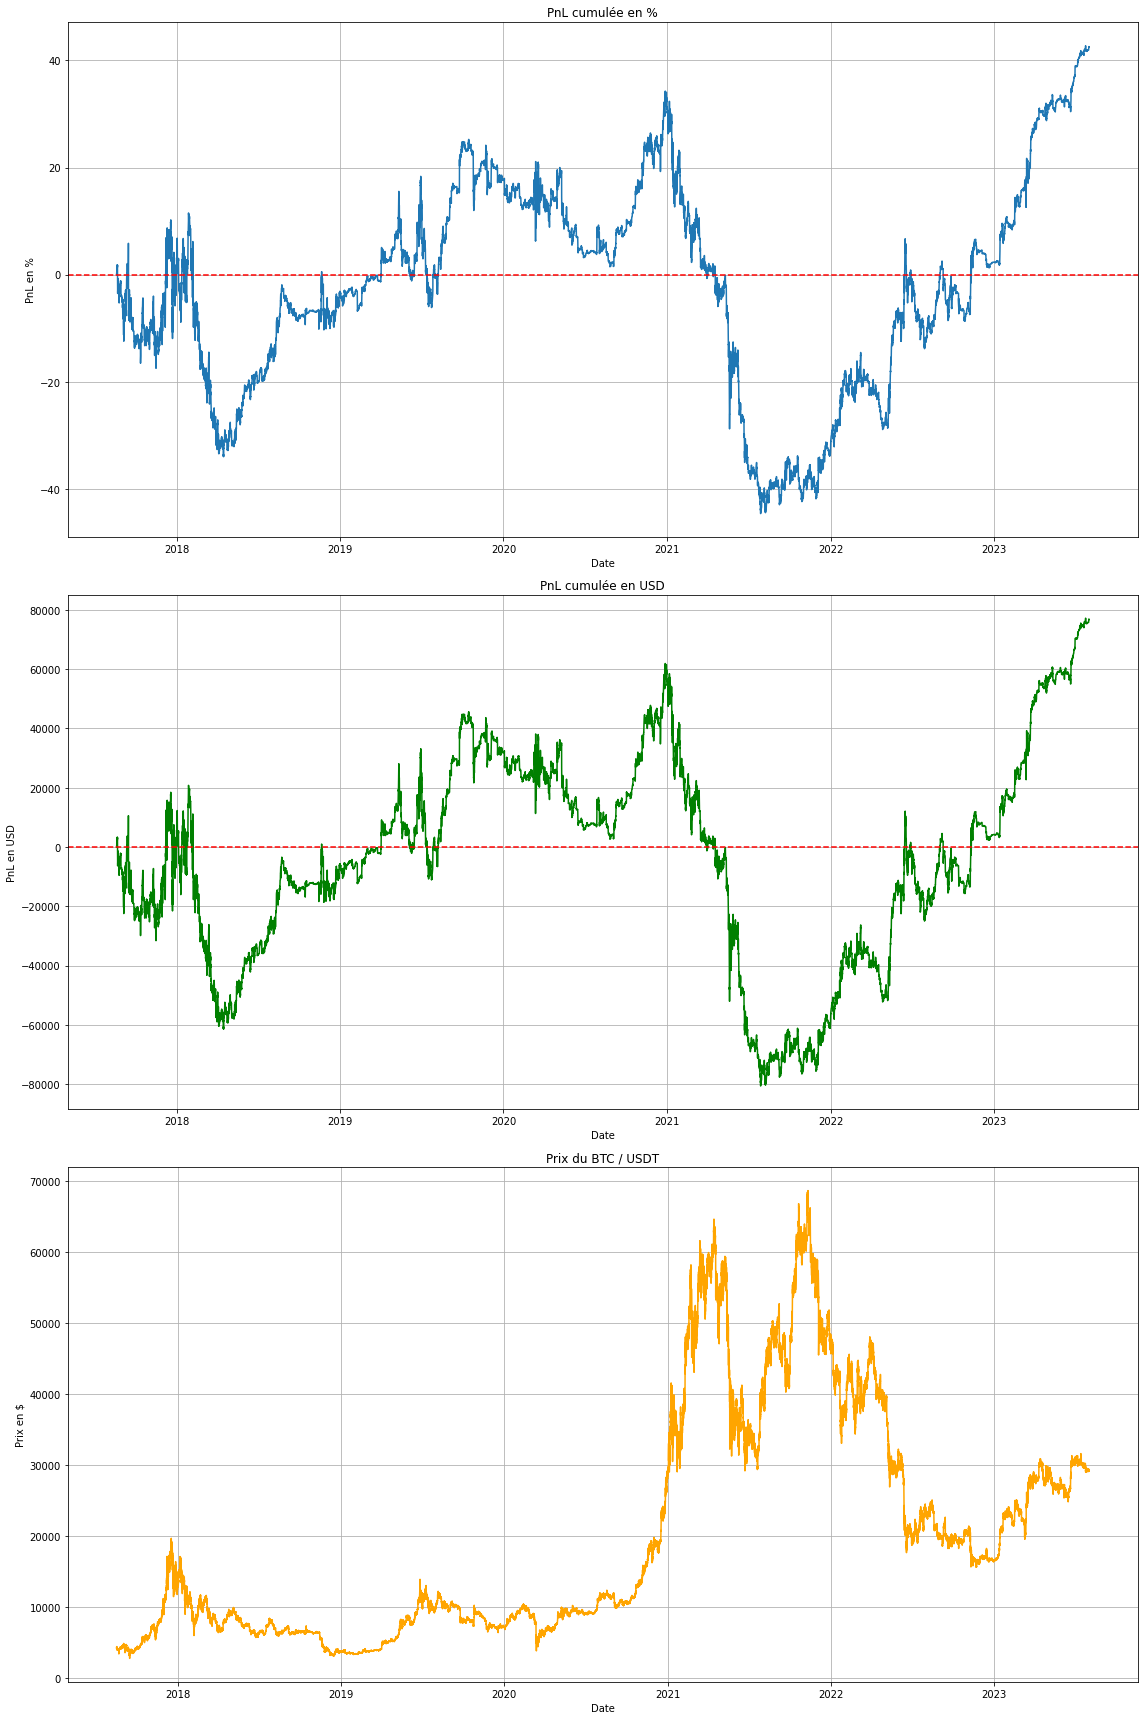

In [84]:
trades_dfs_list[0]["Date_exit"] = pd.to_datetime(trades_dfs_list[0]["Date_exit"])

# Crée une figure et un ensemble de subplots
fig, axs = plt.subplots(3, 1, figsize=(16, 24))  # 3 lignes, 1 colonne, taille totale de (16, 24)

# Premier subplot (ligne 1)
axs[0].plot(trades_dfs_list[0]["Date_exit"], trades_dfs_list[0]["PnL_percent_cum"])
axs[0].set_title('PnL cumulée en %')
axs[0].set_xlabel('Date')
axs[0].set_ylabel('PnL en %')
axs[0].axhline(y=0, linestyle='--', color='red')
axs[0].grid()

# Deuxième subplot (ligne 2)
axs[1].plot(trades_dfs_list[0]["Date_exit"], trades_dfs_list[0]["PnL_USD_cum"], color="green")
axs[1].set_title('PnL cumulée en USD')
axs[1].set_xlabel('Date')
axs[1].set_ylabel('PnL en USD')
axs[1].axhline(y=0, linestyle='--', color='red')
axs[1].grid()

# Troisième subplot (ligne 3)
axs[2].plot(df_selected["Open_time"],df_selected["Close"], color="orange")
axs[2].set_title('Prix du BTC / USDT')
axs[2].set_xlabel('Date')
axs[2].set_ylabel('Prix en $')
axs[2].grid()


# Afficher les graphiques
plt.tight_layout()  # Ajuste automatiquement les paramètres du layout
plt.show()
